In [1]:
from generate_data import Data
from evaluate import *
from models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [4]:
%%time
data = Data(layer_size=16)

Wall time: 935 ms


c:\Users\juand\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [5]:
%%time
train, val, test = data.get_splits(['skip'], [20])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 199 train | 754 val | 3016 test
Wall time: 347 ms


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[[',..._.._,.___._.', 'w,,_,.,_,__.._.,', 'cr__,._,._,._,__', False],
 [',__,.__._,.__,..', '.w,,.,.,.,._,_,.', ',..._cr,,.,..,_,', False],
 [',_.._._,,..,.,.,', ',_w,,,..___,__.,', '____.,,,_.cr___,', False],
 ['._,..,,.__.._.__', '..,_w..__._,__.,', 'cr.,,_.,.._,_,..', False],
 [',..,.,..____.___', ',..,_w_,,_.,,.,_', ',__._cr_._._,_.,', False],
 [',__._._,.,._.,,,', '__.,,.w,..,.__._', ',_,._..,,_cr_,.,', False],
 [',._.,_,_,,,,__.,', '._.,,.,,w_.,..__', 'cr_._,_._.,,__.,', False],
 ['._.,.,_,_,.,__._', ',___,,._,w__.._.', '_,.,,cr.,_.,,,,.', False],
 ['._,.,.,__,.._._.', ',_,__..,__w,_...', ',,_..,.,..cr._.,', False],
 ['.__,__.,_,,.,,,.', ',_._,._..__,w.,,', 'cr._,_,___,,_,_.', False],
 [',._,.,_..__._.__', '_,_.,_,,,.,,,w_.', '.,,._cr_._,,__,.', False],
 ['_,.._,_,,__,_,_.', '.___.,.__.._..w.', ',,,_.,...,cr_._,', False],
 ['...,_...,,_,._.,', 'w,.._,_.__,._..,', 'dr,,..._,,...__.', True],
 ['___,..,.._.,,.,_', '.w_,_,,.,,,._,,_', '__.,,dr.,,.._,,_', True],
 ['._._.,..._.,,.,_', 

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 11 | F2-uw 12 | F2-w 12 | F2-noop 13 | 
F3 cr:    F2-wu 11 | F2-uw 11 | F2-w 12 | F2-noop 13 | 
F3 r:    F2-wu 12 | F2-uw 12 | F2-w 13 | F2-noop 13 | 
F3 noop:    F2-wu 13 | F2-uw 12 | F2-w 14 | F2-noop 15 | 

Positive samples count: 87
Total samples count: 199
Positive class ratio: 0.4371859296482412


#### Peek at test data

In [8]:
test_original[:15]

[[',._,.,._,.,.,._.', '._,,_.___.,,__..', '.,.,,.,.,,r__.,_', True],
 ['__,,._,..,,,._,_', 'w_.___,.,,,.,,._', '__..__.,.,,cr._.', False],
 ['_,..,.__.,.,..,,', '.._.,_._,,_,._wu', '_,.,_._._..dr__.', False],
 [',_.,,.___.,__,_.', '.,,._,,,.,uw,.._', '__,r___,,,_,_,._', True],
 ['_.,...._,.,.....', '_.uw,_._,.,...._', ',._.,..,_,,._r,.', True],
 ['_._...,._,_,._.,', '.__,_._uw.,__,__', ',.,,..,,._.r,_.,', True],
 [',_,_..__,__,_.,,', ',_,.,.,.__wu_,_,', '_._,,.__.__.,_r,', True],
 [',_.,_.,,...._.,_', '___.,,w.,.,,_,..', '.,_...,dr_,_....', True],
 ['_._,,...,,__,.,,', ',.,,.,.,_..uw_.,', ',..,.._r_,,__,_.', True],
 ['_,___,_...,,..__', ',...w_,,.._._,._', ',.,_.__,,,,___,_', False],
 ['___.,,_.,___.,,_', 'w__,,.,___,.._,_', '_,._.,.,dr,,.,__', True],
 ['.,_.,,_,.,,_,._.', ',,,,_,__,_..,,..', ',,.,,_,_.,.,___.', False],
 ['..,__._,_,.,__._', ',_..,....,,,__,_', '_cr_,__,__..,_..', False],
 [',__,_..__.,_.,,,', ',,_,_.._._uw,_..', '.cr..._,,,.,__..', False],
 ['_,...,_,,.._,,_,', ',...w

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 171 | F2-uw 172 | F2-w 180 | F2-noop 193 | 
F3 cr:    F2-wu 173 | F2-uw 166 | F2-w 180 | F2-noop 202 | 
F3 r:    F2-wu 176 | F2-uw 191 | F2-w 200 | F2-noop 207 | 
F3 noop:    F2-wu 190 | F2-uw 208 | F2-w 194 | F2-noop 213 | 

Positive samples count: 1319
Total samples count: 3016
Positive class ratio: 0.4373342175066313


#### Peek at val data

In [10]:
val_original[:15]

[['._.,___.__,,_.,,', '__,.__.uw.,.,,._', '.,,_,.,,,,.,dr,.', True],
 [',..,,.,.._._..,,', '_.,,..,.....w.__', '_..,._,_,,..,_,_', False],
 ['_.,._,.__,,,____', '__.,_,_..,,,_,_.', '.,.__,.,_,_cr...', False],
 ['._,..,,._,..__..', '.__,wu_,.,,_._._', '.,r,_,._,,,_.,_,', True],
 ['.,__..__,..,....', '._,.,,,_.w_..__,', '_.dr..._.,.,._.,', True],
 [',,,.,__._._.,...', ',___,,,.,.,,,w__', '__,,__,,,,_.,.._', False],
 ['.,..__..,,._,,__', ',..,.,___w_,,,,,', '.._..,_._.._,cr.', False],
 [',__,,,_.,,_,_,._', 'w,,,.,.....,,_,,', ',,,,.,,...._,_..', False],
 ['.,.,_.,__..,,_.,', '.,_uw,,,,_.,.,_,', '__..,_,,.,,_r_,,', True],
 ['._,_...__.,..._,', '.____,,uw.,_,...', '.....,._._,,.,__', False],
 ['_.._,,.,,,,,_...', ',,,____.,_,,.uw_', '__.._._,,____.__', False],
 [',,,_,___,_._,...', ',,..,w.._.,,,__,', '_.__..,,._,_._,.', False],
 ['..,.,..,.__.,...', ',,______.,,.,,uw', '._.,__,,dr..,.,_', True],
 [',_,_._.._,__,,_.', ',_,,_,_,_,,._,_w', '__._,,r..,.,,._,', True],
 ['__..__,,____,,__', '..,

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 43 | F2-uw 41 | F2-w 48 | F2-noop 49 | 
F3 cr:    F2-wu 41 | F2-uw 48 | F2-w 48 | F2-noop 40 | 
F3 r:    F2-wu 52 | F2-uw 37 | F2-w 43 | F2-noop 52 | 
F3 noop:    F2-wu 52 | F2-uw 35 | F2-w 64 | F2-noop 61 | 

Positive samples count: 322
Total samples count: 754
Positive class ratio: 0.4270557029177719


#### Send label arrays to device

In [12]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([199, 128])

#### Get data in convolutional format, send to device

In [15]:
x_train_cnn = data.to_conv_format(x_train)
x_val_cnn = data.to_conv_format(x_val)
x_test_cnn = data.to_conv_format(x_test)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([199, 128])

#### Get data in LSTM format, send to device

In [17]:
x_train_lstm = data.to_lstm_format(x_train)
x_val_lstm = data.to_lstm_format(x_val)
x_test_lstm = data.to_lstm_format(x_test)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [18]:
x_train_lstm[0].shape

torch.Size([199, 16, 8])

### Define training parameters

In [19]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100
experiment_name = "skip20"

### Define training procedure for each model

In [20]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    wrong_preds = []
    best_accuracy = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-pos_train_ratio)/pos_train_ratio]).to(device))
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./{model_name}_model_TEMP_{experiment_name}')    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./{model_name}_model_TEMP_{experiment_name}'))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original))
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1s.append(get_f1(precisions[-1], recalls[-1]))
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./best_{model_name}_model_{experiment_name}')    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model test accuracy:", accuracies[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test precision:", precisions[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test recall:", recalls[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test f1:", f1s[-1]['Overall'])
    return accuracies, precisions, recalls, f1s, wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [21]:
%%time
cnn_accuracies, cnn_precisions, cnn_recalls, cnn_f1s, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.0001, data, 64, 128, 4, -1, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_55860\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.9598806366047745
1 / 20 models trained | Current model test precision: 0.9665109034267912
1 / 20 models trained | Current model test recall: 0.9408642911296436
1 / 20 models trained | Current model test f1: 0.9535151747983096
2 / 20 models trained | Current model test accuracy: 0.9701591511936339
2 / 20 models trained | Current model test precision: 0.9673003802281369
2 / 20 models trained | Current model test recall: 0.9643669446550417
2 / 20 models trained | Current model test f1: 0.9658314350797266
3 / 20 models trained | Current model test accuracy: 0.9704907161803713
3 / 20 models trained | Current model test precision: 0.9752704791344667
3 / 20 models trained | Current model test recall: 0.9567854435178166
3 / 20 models trained | Current model test f1: 0.9659395331037122
4 / 20 models trained | Current model test accuracy: 0.9545755968169761
4 / 20 models trained | Current model test precision: 0.97508038585209
4 / 20 models 

In [22]:
%%time
lstm_accuracies, lstm_precisions, lstm_recalls, lstm_f1s, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_55860\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.9419761273209549
1 / 20 models trained | Current model test precision: 0.8828647925033467
1 / 20 models trained | Current model test recall: 1.0
1 / 20 models trained | Current model test f1: 0.937788837539993
2 / 20 models trained | Current model test accuracy: 0.9161140583554377
2 / 20 models trained | Current model test precision: 0.8701388888888889
2 / 20 models trained | Current model test recall: 0.9499620924943138
2 / 20 models trained | Current model test f1: 0.908300108735049
3 / 20 models trained | Current model test accuracy: 0.9366710875331565
3 / 20 models trained | Current model test precision: 0.8841961852861036
3 / 20 models trained | Current model test recall: 0.9840788476118272
3 / 20 models trained | Current model test f1: 0.9314675278076785
4 / 20 models trained | Current model test accuracy: 0.9429708222811671
4 / 20 models trained | Current model test precision: 0.8846411804158283
4 / 20 models trained | Curre

In [23]:
%%time
deepset_accuracies, deepset_precisions, deepset_recalls, deepset_f1s, deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_55860\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.5862068965517241
1 / 20 models trained | Current model test precision: 0.5297071129707113
1 / 20 models trained | Current model test recall: 0.4799090219863533
1 / 20 models trained | Current model test f1: 0.5035799522673032
2 / 20 models trained | Current model test accuracy: 0.60842175066313
2 / 20 models trained | Current model test precision: 0.5510355029585798
2 / 20 models trained | Current model test recall: 0.5648218347232752
2 / 20 models trained | Current model test f1: 0.5578435043055034
3 / 20 models trained | Current model test accuracy: 0.6153846153846154
3 / 20 models trained | Current model test precision: 0.5645816409423233
3 / 20 models trained | Current model test recall: 0.5269143290371494
3 / 20 models trained | Current model test f1: 0.5450980392156862
4 / 20 models trained | Current model test accuracy: 0.6021220159151194
4 / 20 models trained | Current model test precision: 0.5771725032425421
4 / 20 models 

In [24]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recalls, deepsetv2_f1s, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_55860\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.4373342175066313
1 / 20 models trained | Current model test precision: 0.4373342175066313
1 / 20 models trained | Current model test recall: 1.0
1 / 20 models trained | Current model test f1: 0.6085351787773934
2 / 20 models trained | Current model test accuracy: 0.4373342175066313
2 / 20 models trained | Current model test precision: 0.4373342175066313
2 / 20 models trained | Current model test recall: 1.0
2 / 20 models trained | Current model test f1: 0.6085351787773934
3 / 20 models trained | Current model test accuracy: 0.4373342175066313
3 / 20 models trained | Current model test precision: 0.4373342175066313
3 / 20 models trained | Current model test recall: 1.0
3 / 20 models trained | Current model test f1: 0.6085351787773934
4 / 20 models trained | Current model test accuracy: 0.4373342175066313
4 / 20 models trained | Current model test precision: 0.4373342175066313
4 / 20 models trained | Current model test recall: 1.0
4 

In [25]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recalls, feedforward_f1s, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_55860\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.6269893899204244
1 / 20 models trained | Current model test precision: 0.5735963581183612
1 / 20 models trained | Current model test recall: 0.5731614859742229
1 / 20 models trained | Current model test f1: 0.5733788395904437
2 / 20 models trained | Current model test accuracy: 0.5921750663129973
2 / 20 models trained | Current model test precision: 0.5350669818754925
2 / 20 models trained | Current model test recall: 0.514783927217589
2 / 20 models trained | Current model test f1: 0.5247295208655333
3 / 20 models trained | Current model test accuracy: 0.5941644562334217
3 / 20 models trained | Current model test precision: 0.5415573053368329
3 / 20 models trained | Current model test recall: 0.46929492039423804
3 / 20 models trained | Current model test f1: 0.5028432168968319
4 / 20 models trained | Current model test accuracy: 0.5964854111405835
4 / 20 models trained | Current model test precision: 0.5655526992287918
4 / 20 model

# Evaluation

### Get best 50% performing models

In [26]:
top_half = int(num_experiments / 2)
best_cnn_accs = filter_top_k_accuracies(cnn_accuracies, top_half)
best_lstm_accs = filter_top_k_accuracies(lstm_accuracies, top_half)
best_deepset_accs = filter_top_k_accuracies(deepset_accuracies, top_half)
best_deepsetv2_accs = filter_top_k_accuracies(deepsetv2_accuracies, top_half)
best_feedforward_accs = filter_top_k_accuracies(feedforward_accuracies, top_half)

## Accuracy breakdown by cases for all the models

In [27]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [28]:
get_stats_df(all_accuracies, model_names, test_original)

,Overall,cr_noop,cr_uw,cr_w,cr_wu,dr_noop,dr_uw,dr_w,dr_wu,noop_noop,noop_uw,noop_w,noop_wu,r_noop,r_uw,r_w,r_wu
CNN,96.5%,100.0%,100.0%,100.0%,100.0%,97.3%,97.3%,96.2%,74.9%,100.0%,100.0%,100.0%,100.0%,98.3%,97.9%,97.0%,81.7%
LSTM,93.7%,100.0%,100.0%,100.0%,100.0%,99.4%,97.5%,99.6%,3.9%,99.7%,99.8%,99.7%,99.8%,98.4%,97.7%,97.9%,96.8%
DeepSet(like in paper),60.6%,63.4%,64.4%,64.8%,63.3%,53.0%,63.8%,57.6%,43.9%,79.1%,79.9%,77.7%,80.1%,45.2%,46.6%,43.2%,39.0%
DeepSet(sum at start),43.7%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,100.0%
Feedforward,60.4%,65.2%,65.9%,66.1%,66.7%,51.8%,59.0%,54.7%,47.6%,81.4%,81.9%,79.6%,81.9%,42.8%,42.3%,38.8%,37.1%
Sample count,3016,202,166,180,173,193,172,180,171,213,208,194,190,207,191,200,176


## Accuracy breakdown by cases for top 50% of models

In [29]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['dr', 'r', 'cr', 'noop']

In [30]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN,97.2%,100.0%,94.0%,100.0%,94.6%
LSTM,94.4%,100.0%,76.8%,100.0%,99.5%
DeepSet(like in paper),62.0%,60.6%,57.3%,81.1%,47.6%
DeepSet(sum at start),43.7%,0.0%,76.1%,0.0%,100.0%
Feedforward,62.0%,59.7%,58.8%,80.5%,47.7%
Sample count,3016,721,716,805,774


In [31]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['r', 'cr', 'noop']

In [32]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,dr_noop,dr_uw,dr_w,dr_wu,f3_cr,f3_noop,f3_r
CNN,97.2%,100.0%,100.0%,99.5%,75.3%,100.0%,100.0%,94.6%
LSTM,94.4%,100.0%,98.4%,100.0%,4.4%,100.0%,100.0%,99.5%
DeepSet(like in paper),62.0%,57.9%,71.2%,63.7%,35.8%,60.6%,81.1%,47.6%
DeepSet(sum at start),43.7%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,100.0%
Feedforward,62.0%,63.0%,69.7%,65.4%,36.4%,59.7%,80.5%,47.7%
Sample count,3016,193,172,180,171,721,805,774


## Accuracies per CNN model

In [33]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,96.0%,100.0%,89.2%,100.0%,94.3%
CNN #1,97.0%,100.0%,94.0%,100.0%,93.9%
CNN #2,97.0%,100.0%,95.5%,100.0%,92.6%
CNN #3,95.5%,100.0%,89.5%,100.0%,92.0%
CNN #4,97.1%,100.0%,95.4%,100.0%,92.9%
CNN #5,96.7%,100.0%,91.6%,100.0%,95.0%
CNN #6,97.2%,100.0%,94.7%,100.0%,94.2%
CNN #7,97.0%,100.0%,94.3%,100.0%,93.8%
CNN #8,97.9%,100.0%,94.7%,100.0%,96.8%
CNN #9,95.8%,100.0%,89.8%,100.0%,93.0%


## Accuracies per LSTM model

In [34]:
get_stats_per_model(lstm_accuracies, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,94.2%,100.0%,76.1%,99.5%,100.0%
LSTM #1,91.6%,99.9%,75.3%,96.4%,94.1%
LSTM #2,93.7%,100.0%,75.7%,100.0%,97.8%
LSTM #3,94.3%,100.0%,76.1%,99.9%,100.0%
LSTM #4,92.7%,100.0%,75.4%,100.0%,94.4%
LSTM #5,94.3%,100.0%,76.1%,100.0%,99.7%
LSTM #6,94.0%,100.0%,76.4%,100.0%,98.3%
LSTM #7,90.5%,100.0%,74.6%,99.3%,87.1%
LSTM #8,94.3%,100.0%,76.1%,100.0%,100.0%
LSTM #9,93.2%,100.0%,75.3%,100.0%,96.4%


## Accuracies per DeepSets V1 model

In [35]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,58.6%,64.5%,54.7%,72.0%,42.8%
DeepSet(like in paper) #1,60.8%,57.3%,59.6%,75.9%,49.6%
DeepSet(like in paper) #2,61.5%,63.4%,56.4%,78.8%,46.6%
DeepSet(like in paper) #3,60.2%,78.6%,45.9%,86.5%,28.9%
DeepSet(like in paper) #4,58.6%,62.8%,50.3%,73.8%,46.5%
DeepSet(like in paper) #5,61.5%,61.0%,55.2%,83.0%,45.6%
DeepSet(like in paper) #6,62.2%,61.0%,58.5%,80.6%,47.5%
DeepSet(like in paper) #7,62.7%,59.5%,57.8%,82.1%,50.1%
DeepSet(like in paper) #8,59.9%,64.6%,53.6%,75.8%,44.7%
DeepSet(like in paper) #9,58.8%,62.7%,55.3%,70.8%,45.7%


## Accuracies per DeepSets V2 model

In [36]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,43.7%,0.0%,76.1%,0.0%,100.0%
DeepSet(sum at start) #1,43.7%,0.0%,76.1%,0.0%,100.0%
DeepSet(sum at start) #2,43.7%,0.0%,76.1%,0.0%,100.0%
DeepSet(sum at start) #3,43.7%,0.0%,76.1%,0.0%,100.0%
DeepSet(sum at start) #4,43.7%,0.0%,76.1%,0.0%,100.0%
DeepSet(sum at start) #5,43.7%,0.0%,76.1%,0.0%,100.0%
DeepSet(sum at start) #6,43.7%,0.0%,76.1%,0.0%,100.0%
DeepSet(sum at start) #7,43.7%,0.0%,76.1%,0.0%,100.0%
DeepSet(sum at start) #8,43.7%,0.0%,76.1%,0.0%,100.0%
DeepSet(sum at start) #9,43.7%,0.0%,76.1%,0.0%,100.0%


## Accuracies per FeedForward model

In [37]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,62.7%,58.1%,59.8%,82.4%,49.2%
Feedforward #1,59.2%,60.2%,56.4%,74.2%,45.3%
Feedforward #2,59.4%,66.2%,54.2%,75.2%,41.6%
Feedforward #3,59.6%,75.0%,46.6%,88.1%,27.8%
Feedforward #4,58.0%,67.5%,49.0%,75.0%,39.5%
Feedforward #5,60.8%,59.5%,56.8%,80.6%,45.1%
Feedforward #6,58.5%,83.8%,39.2%,92.2%,17.6%
Feedforward #7,62.2%,59.8%,60.3%,78.3%,49.5%
Feedforward #8,61.2%,62.8%,55.6%,80.4%,45.0%
Feedforward #9,58.0%,88.3%,36.6%,91.9%,14.3%


# Training evolution

### CNN

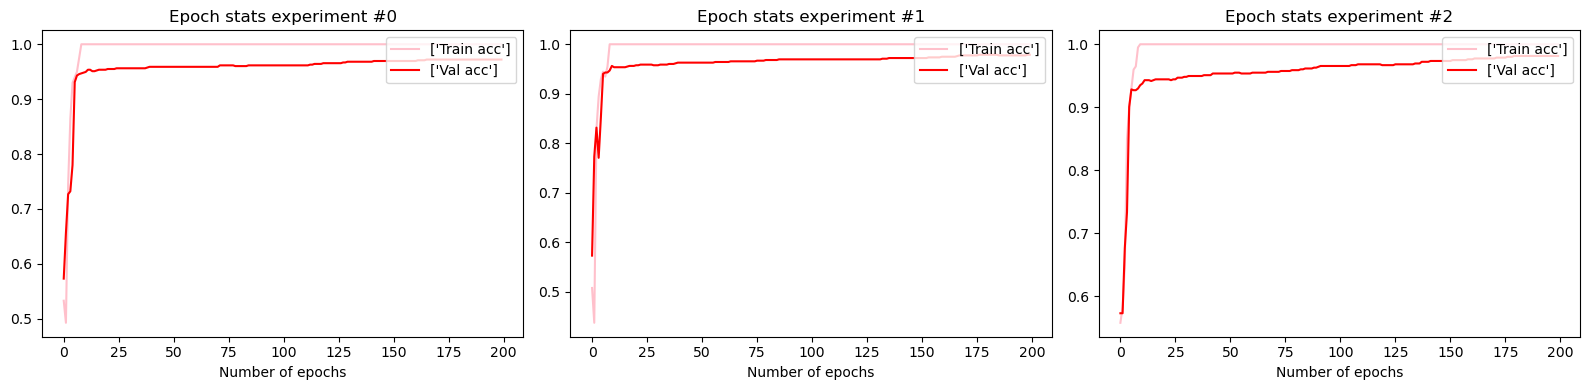

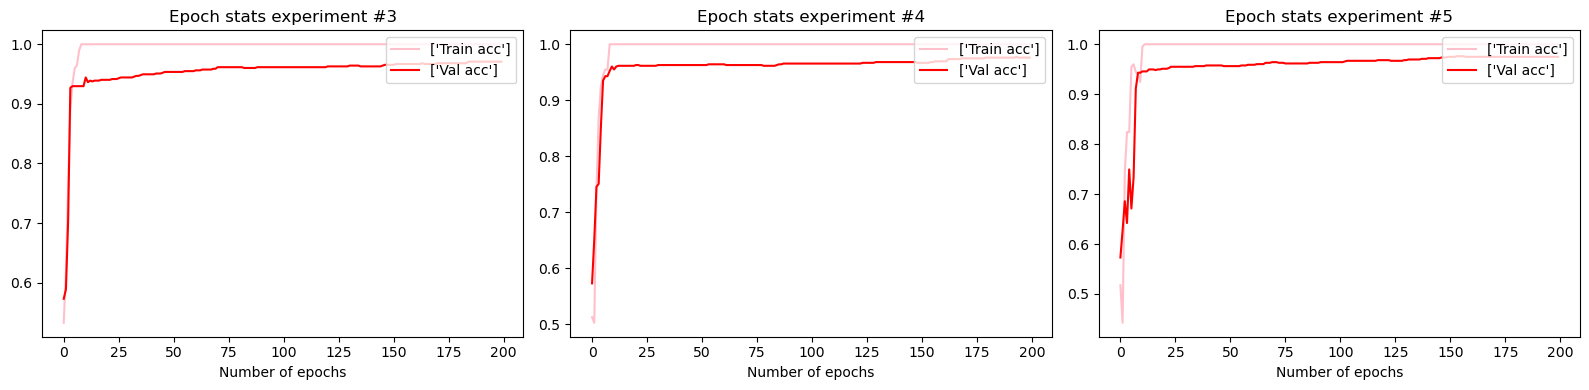

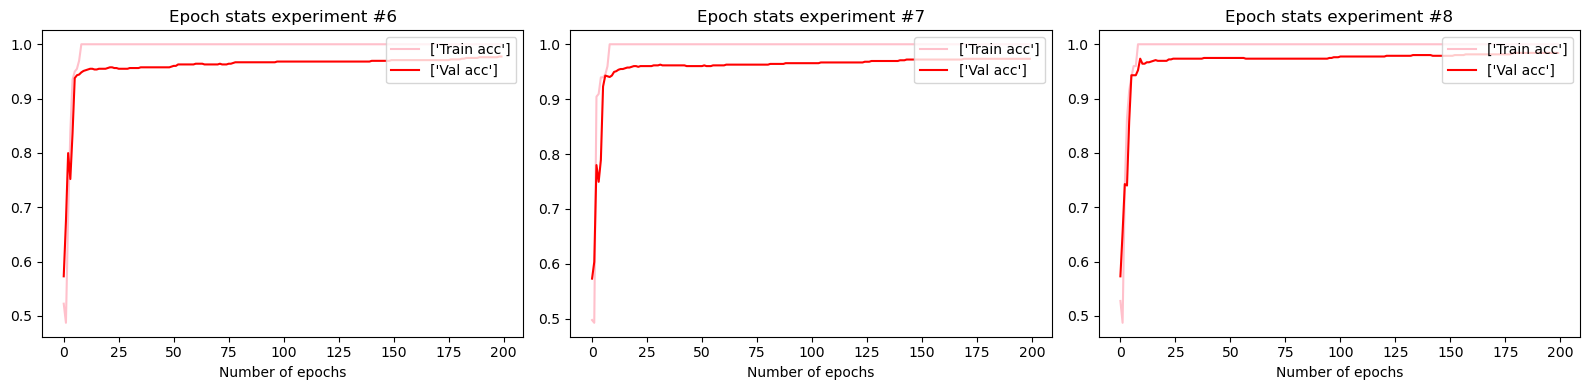

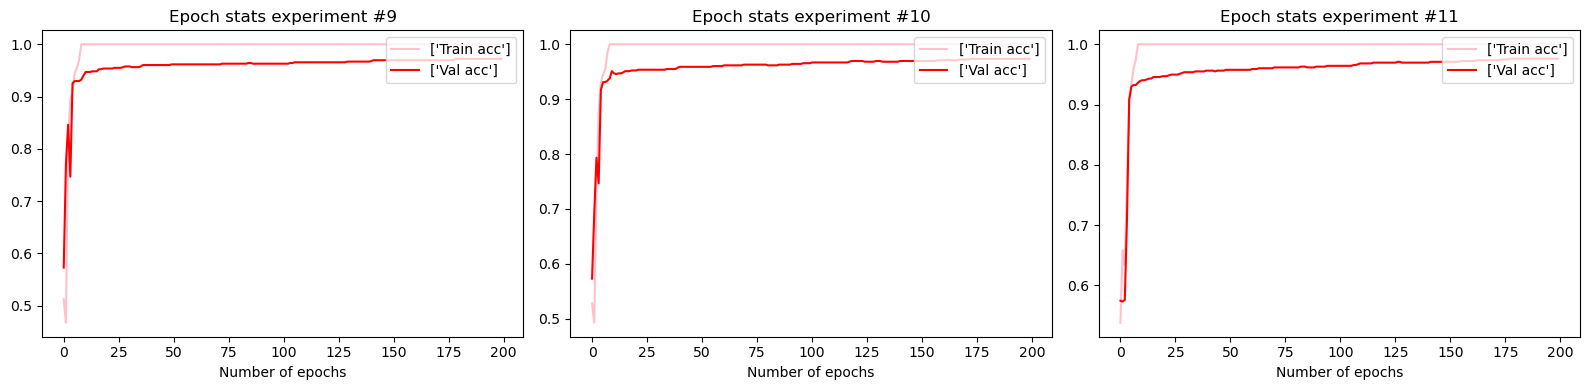

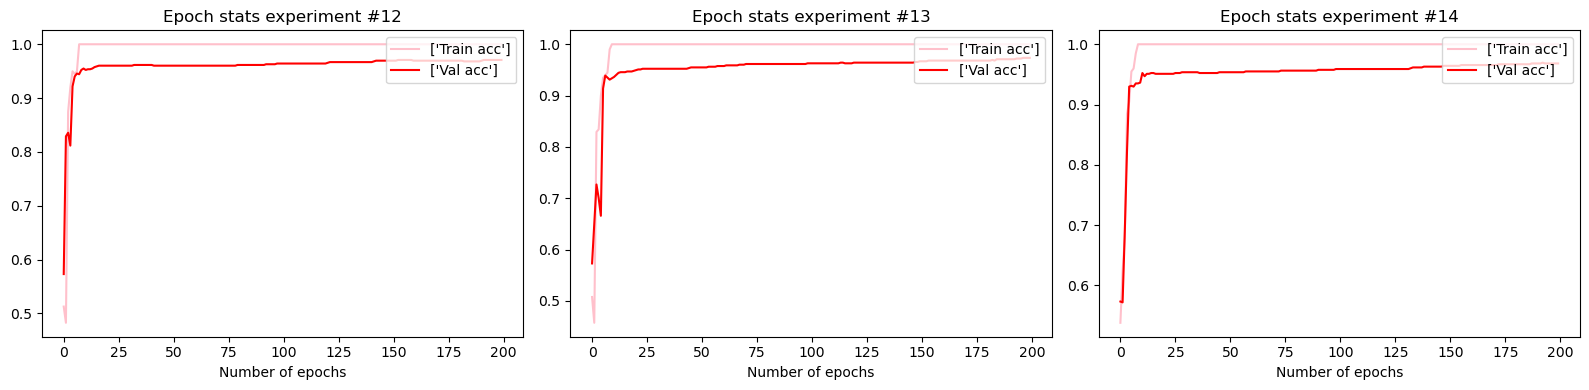

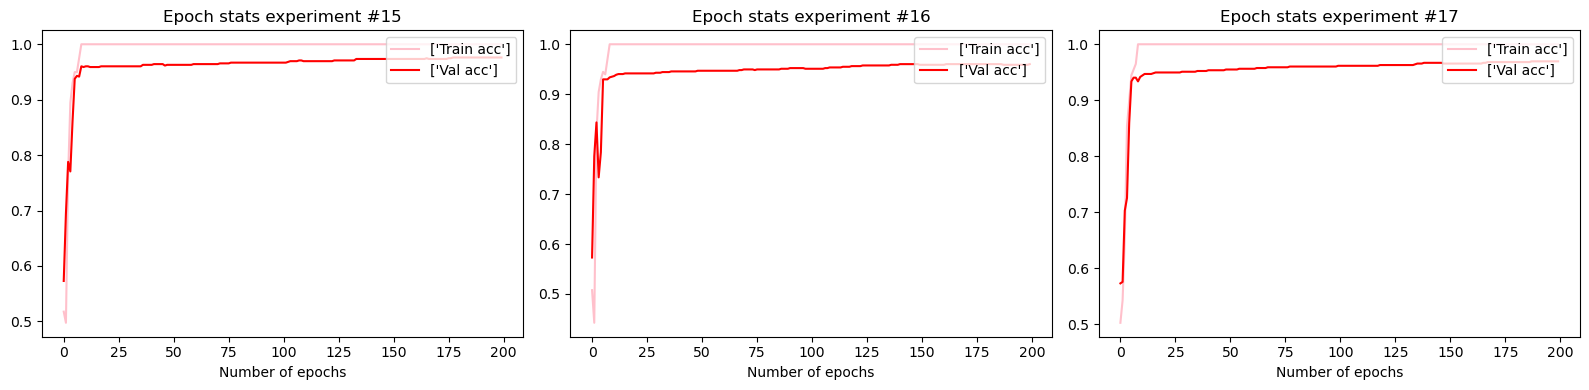

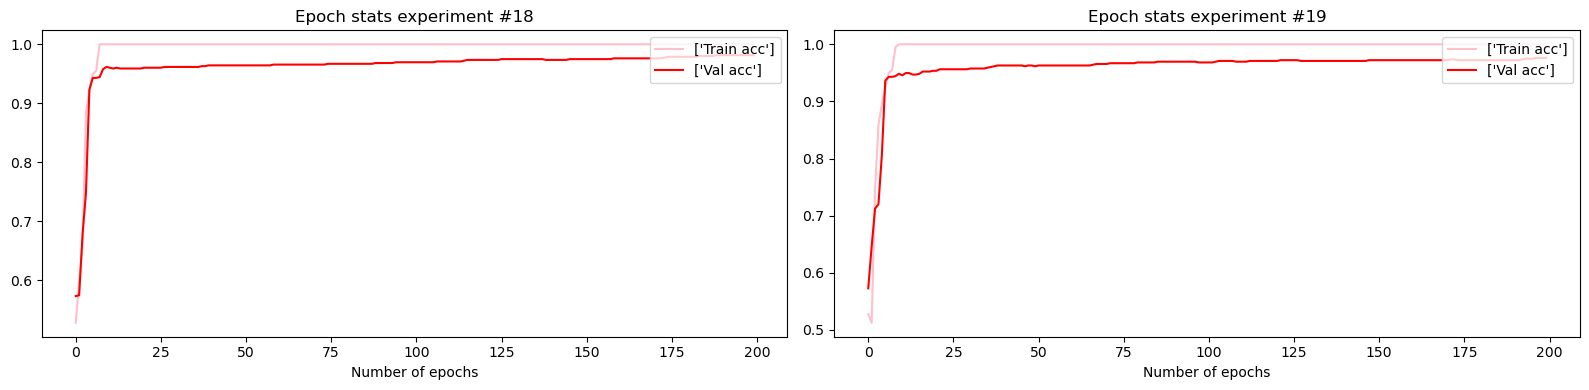

In [38]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

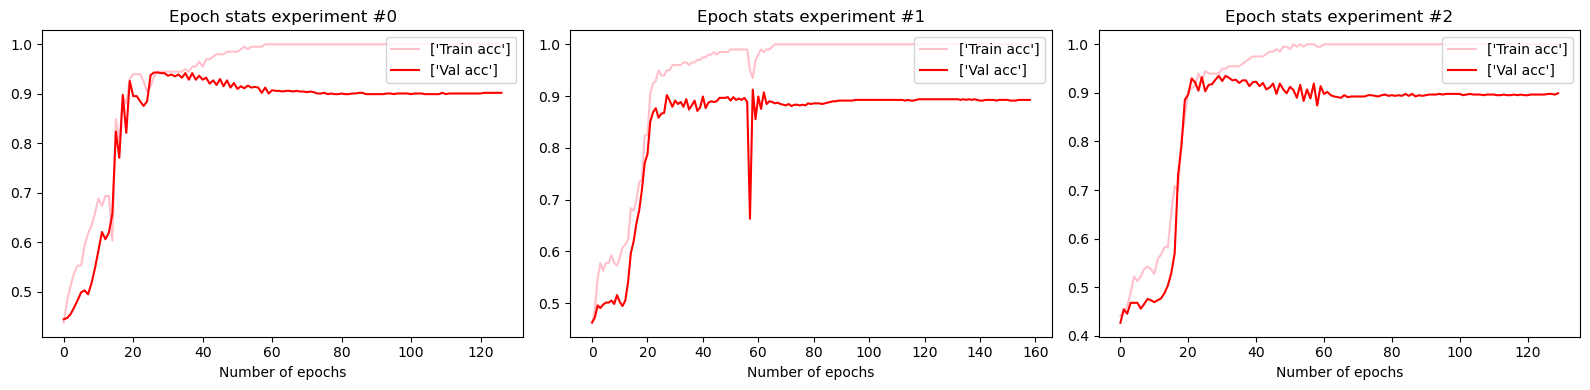

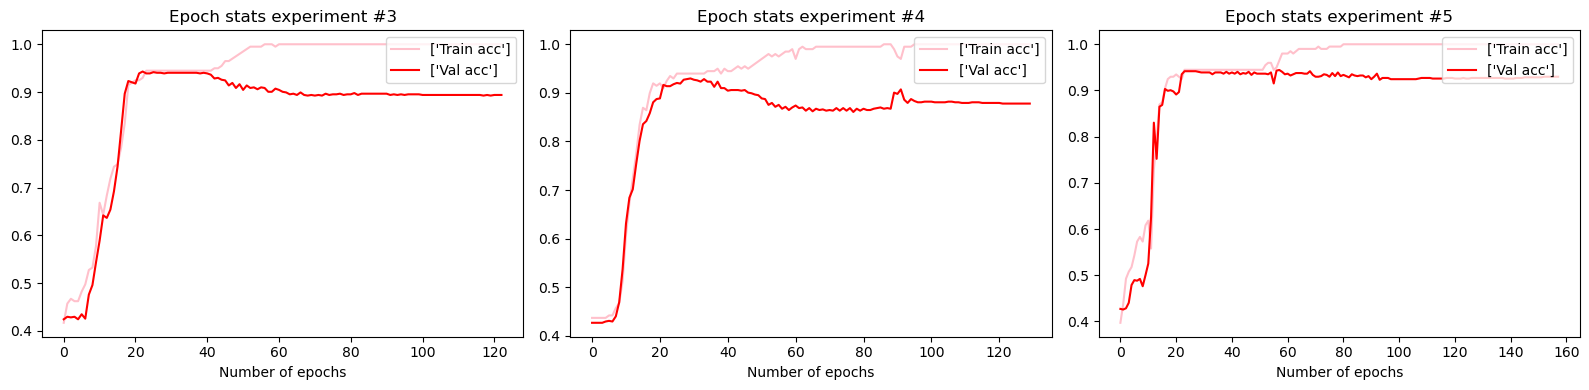

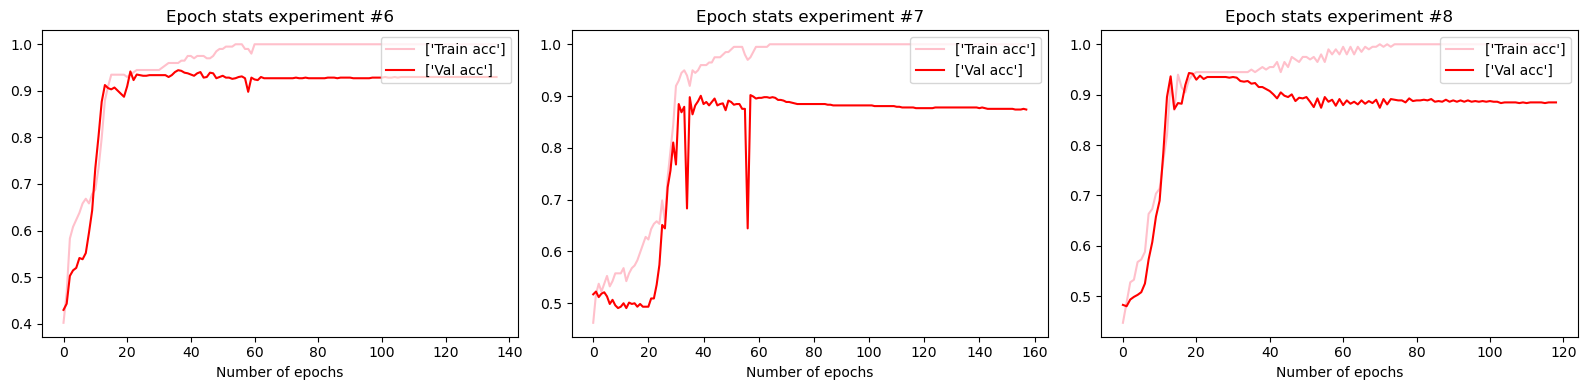

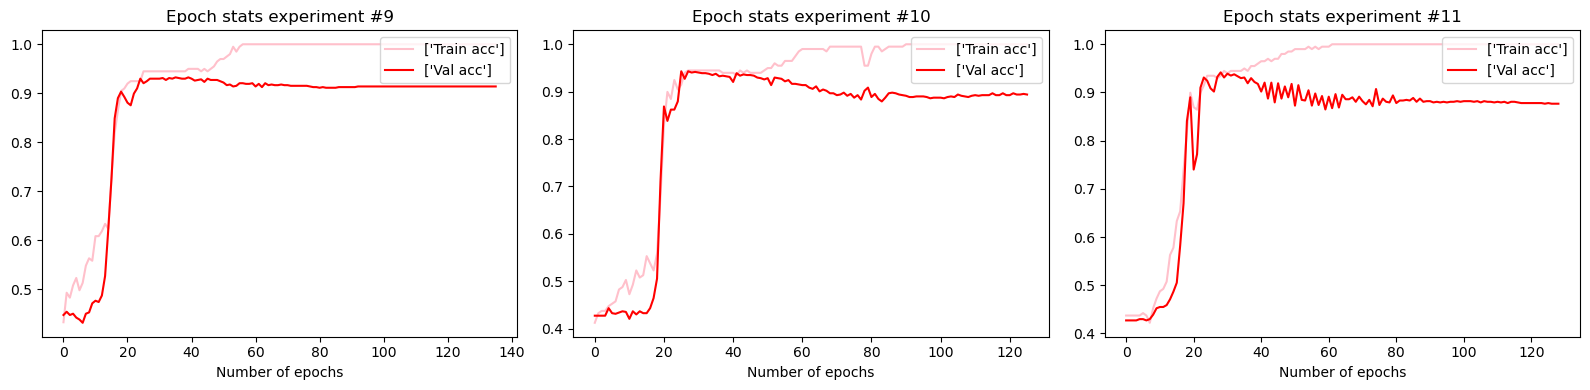

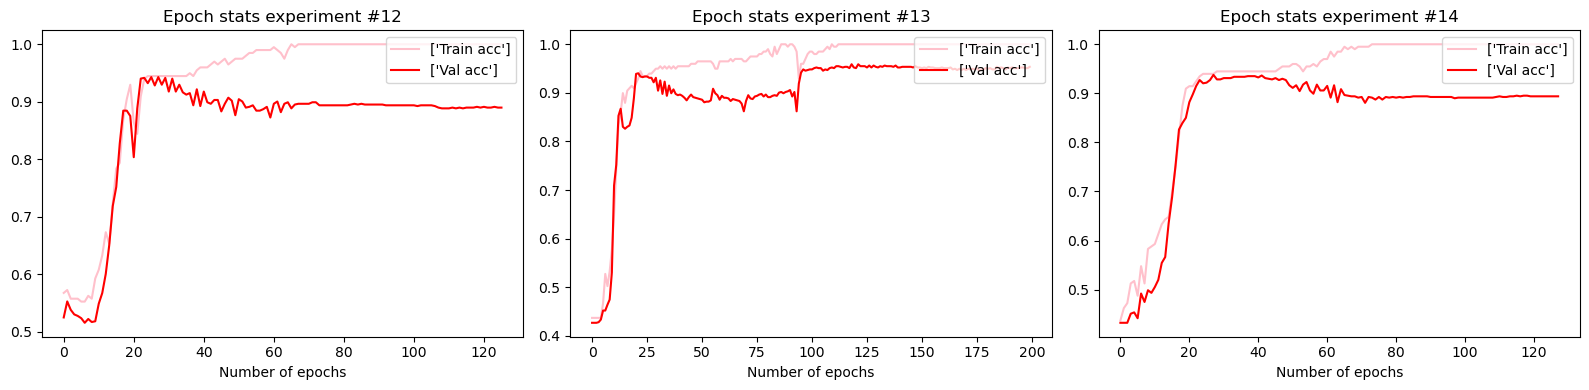

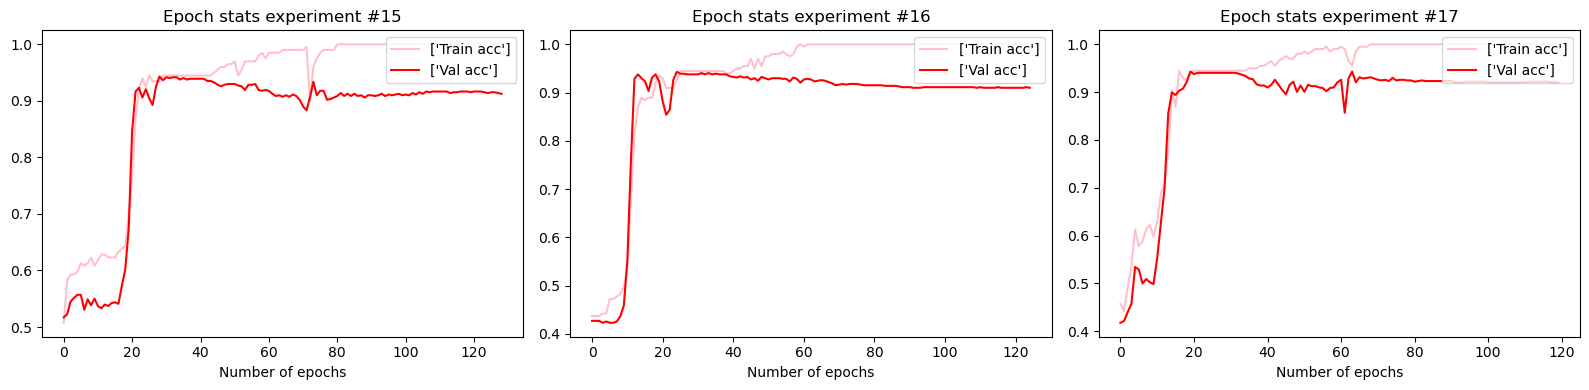

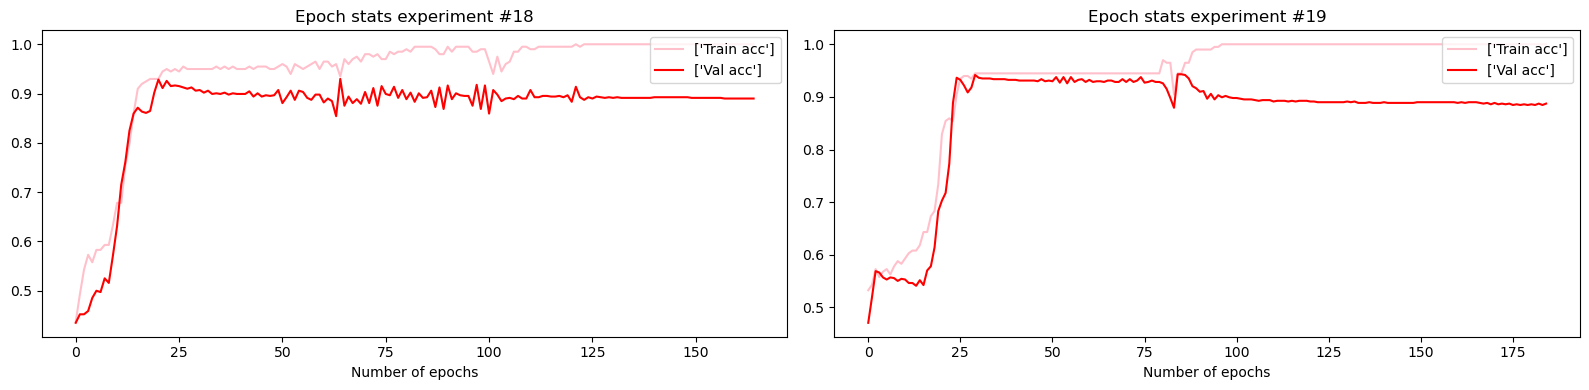

In [39]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

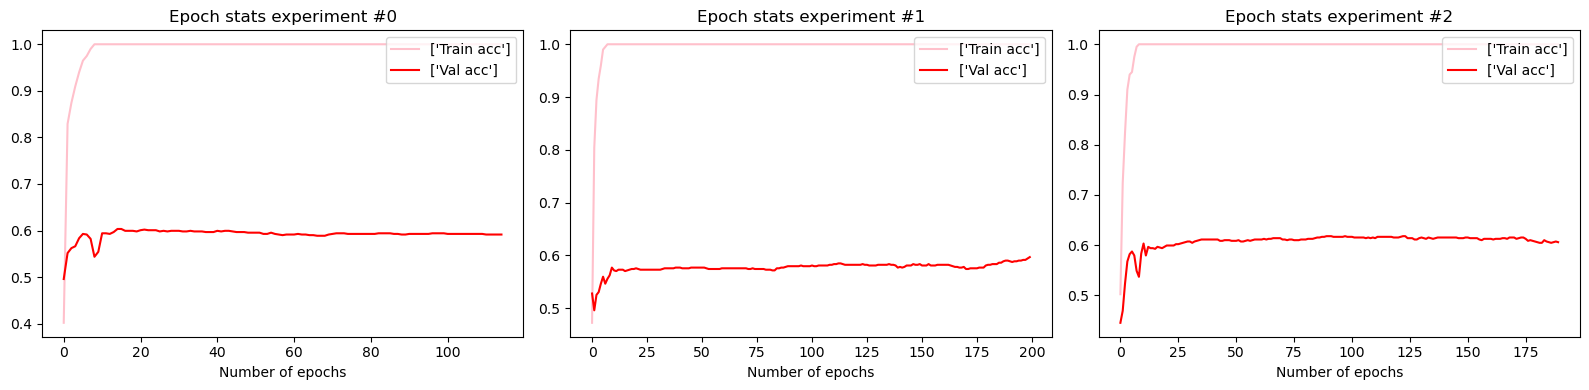

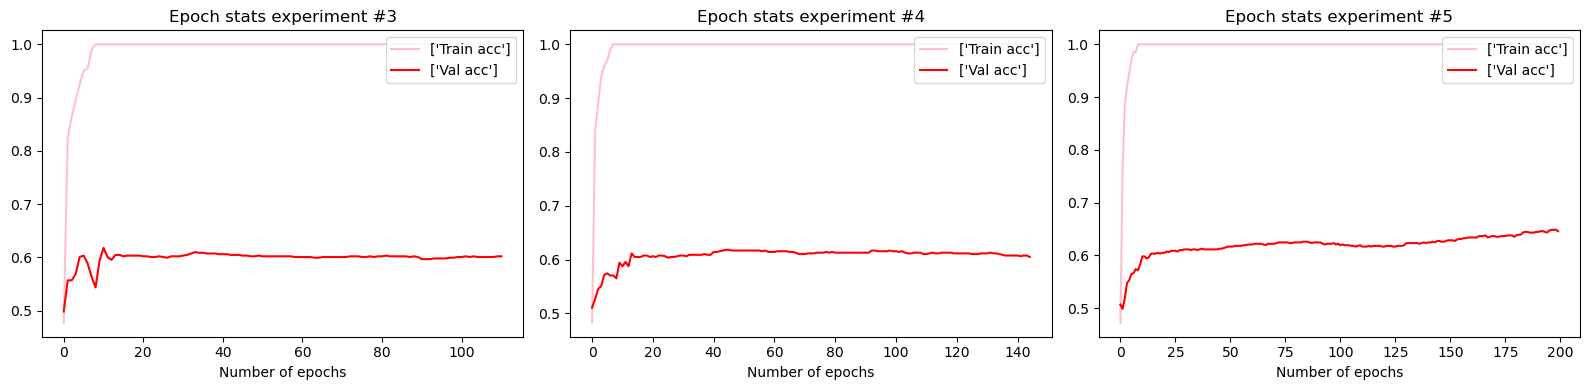

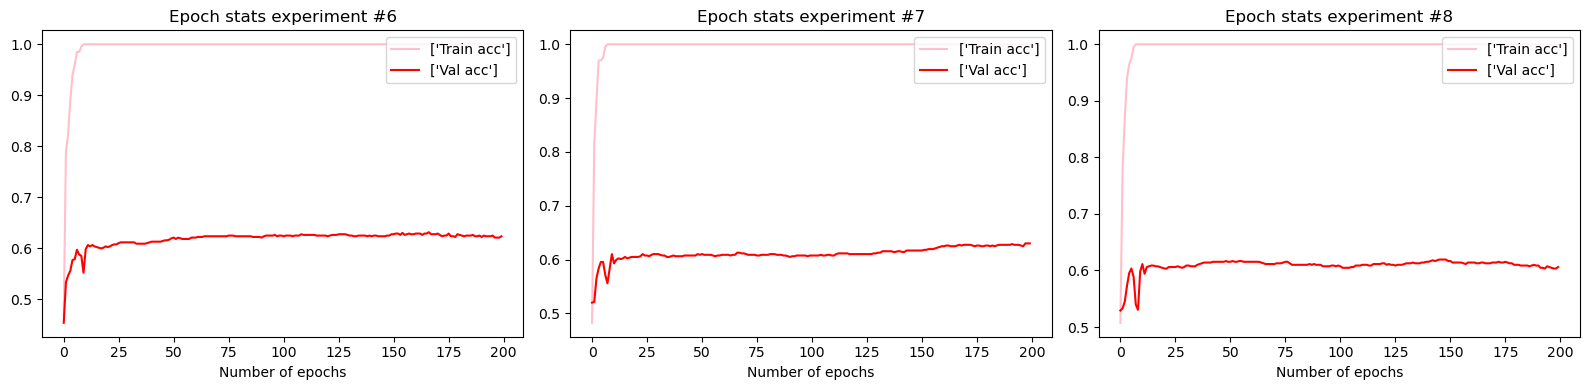

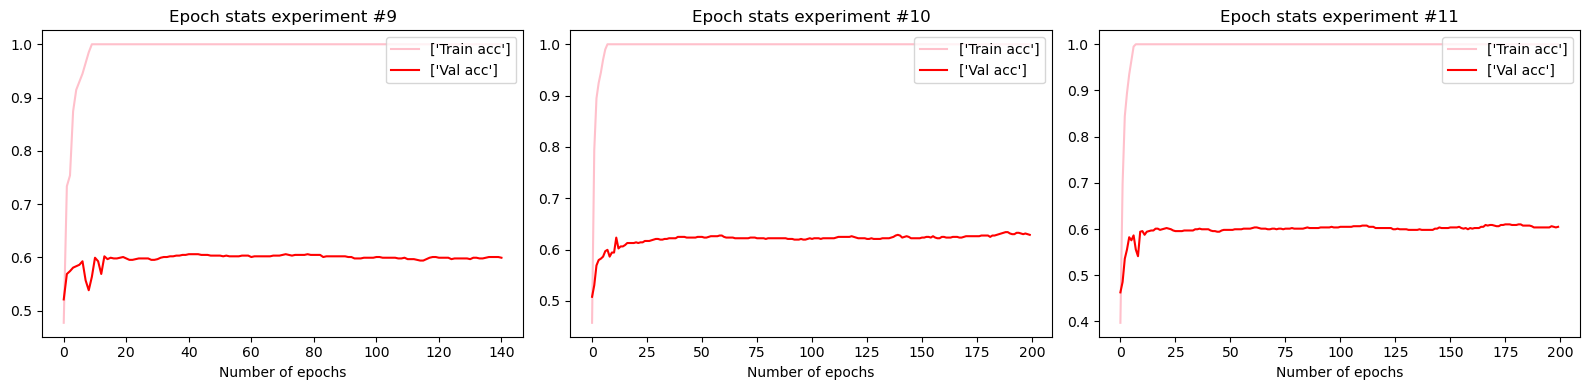

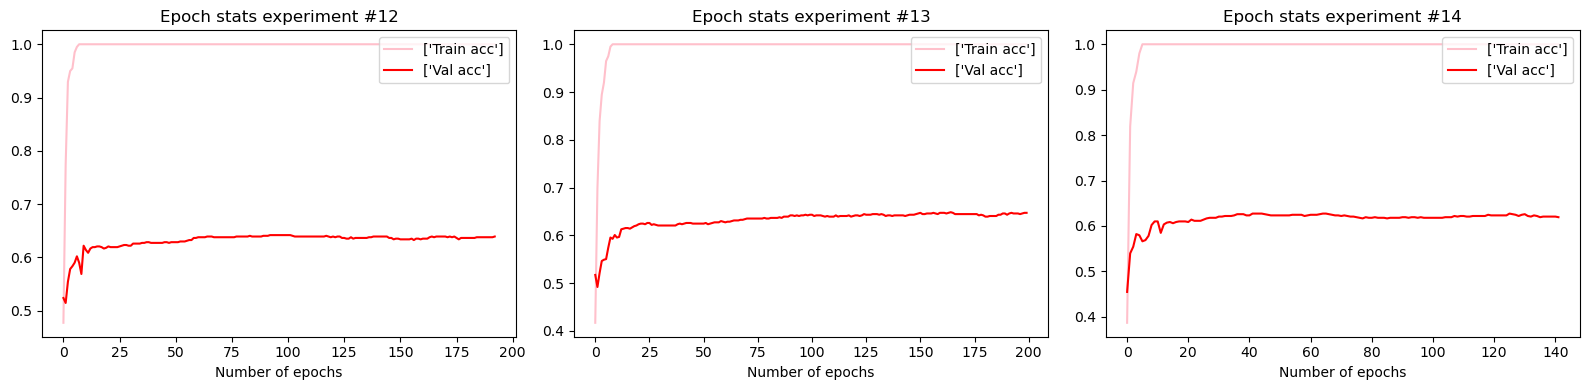

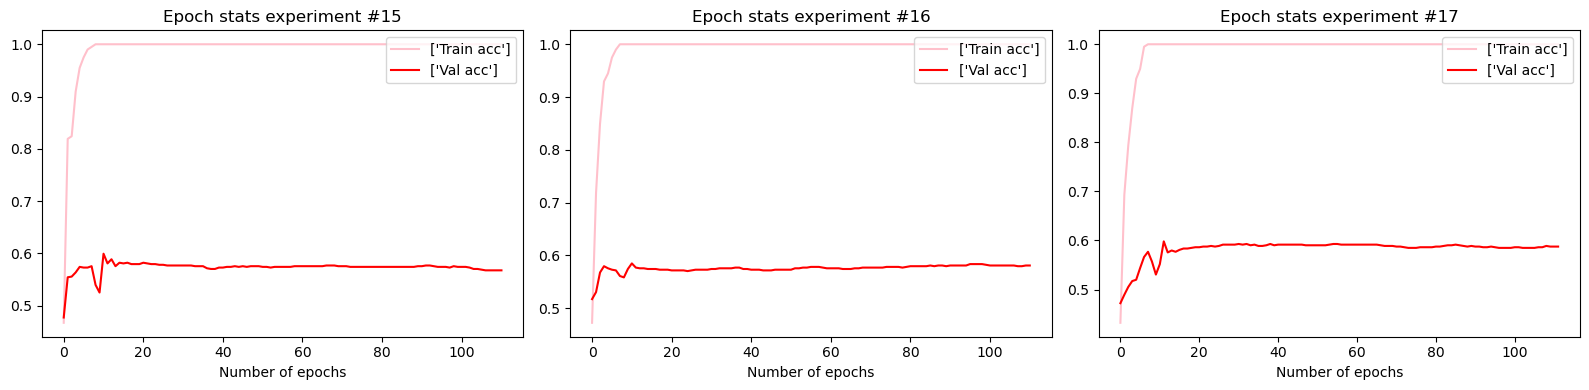

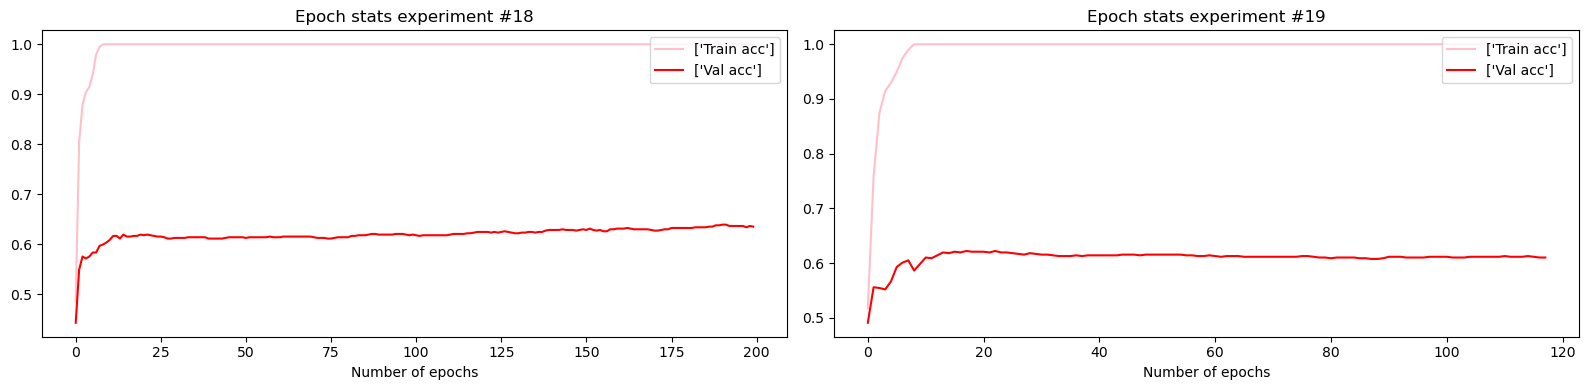

In [40]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

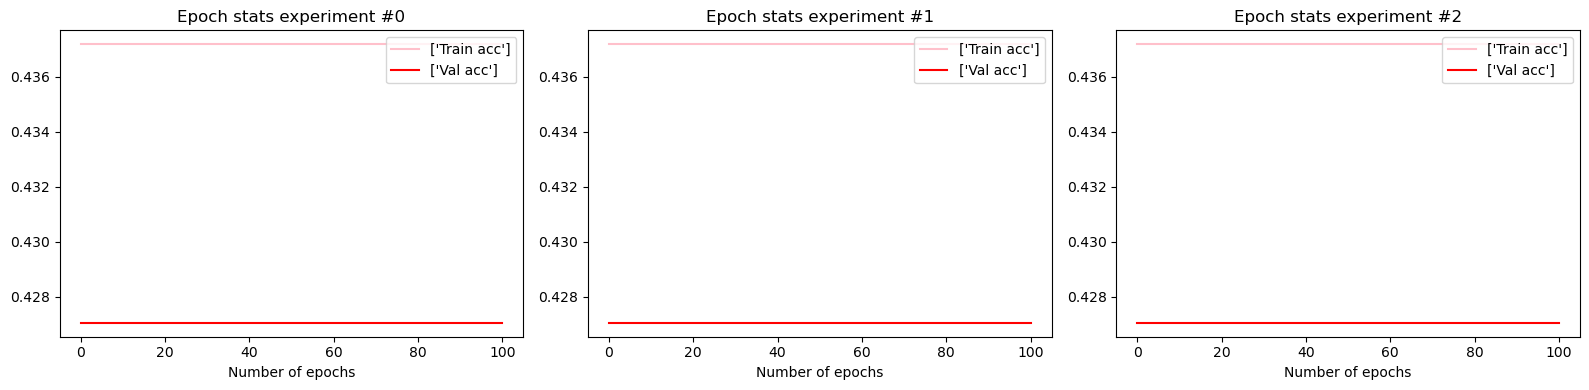

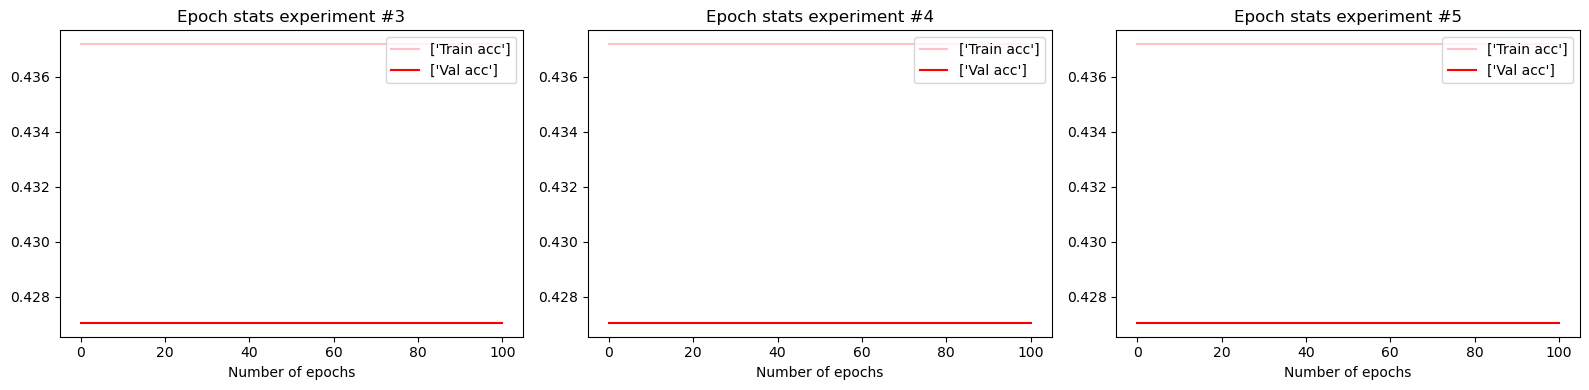

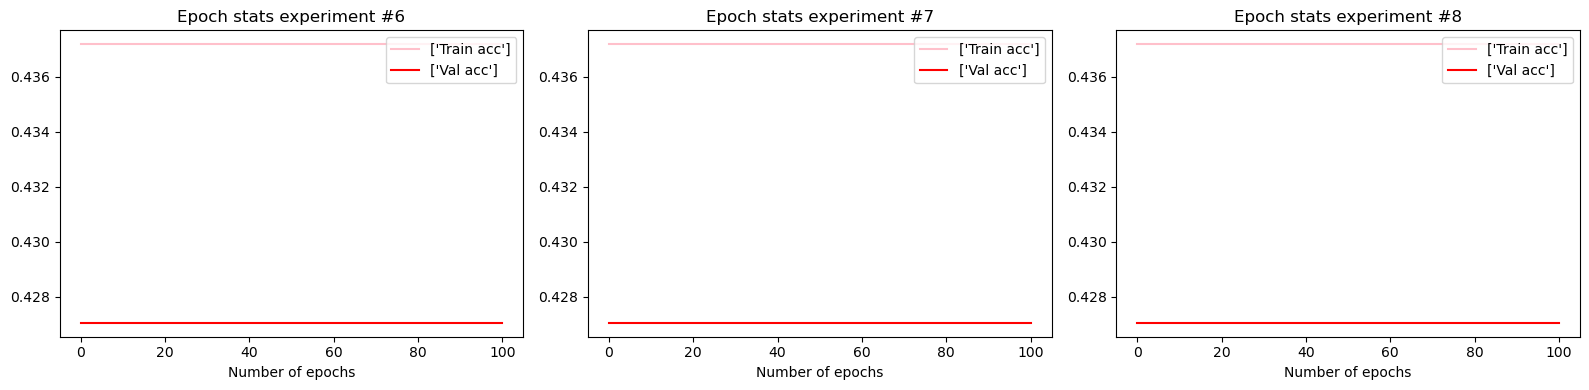

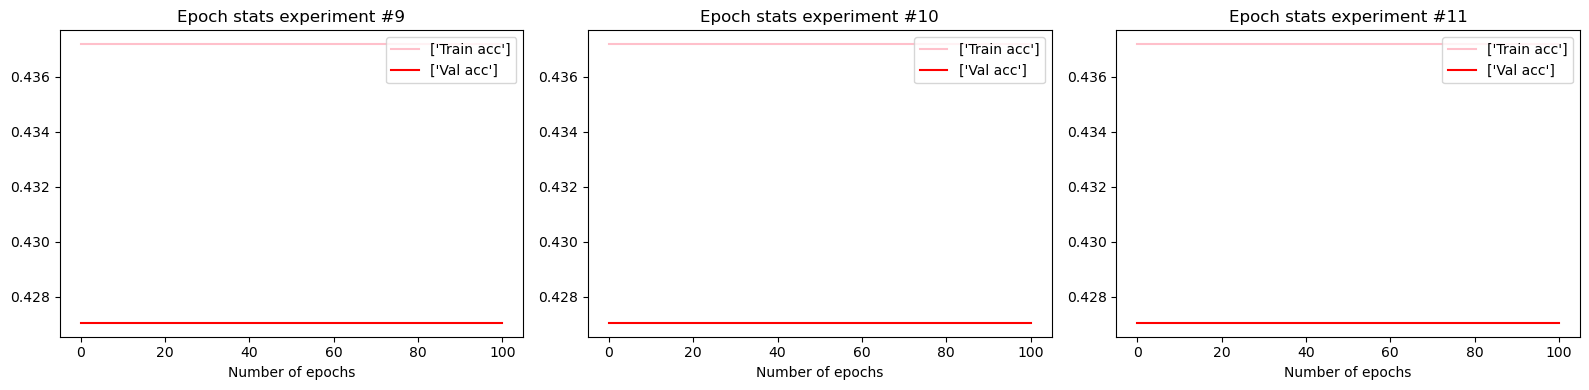

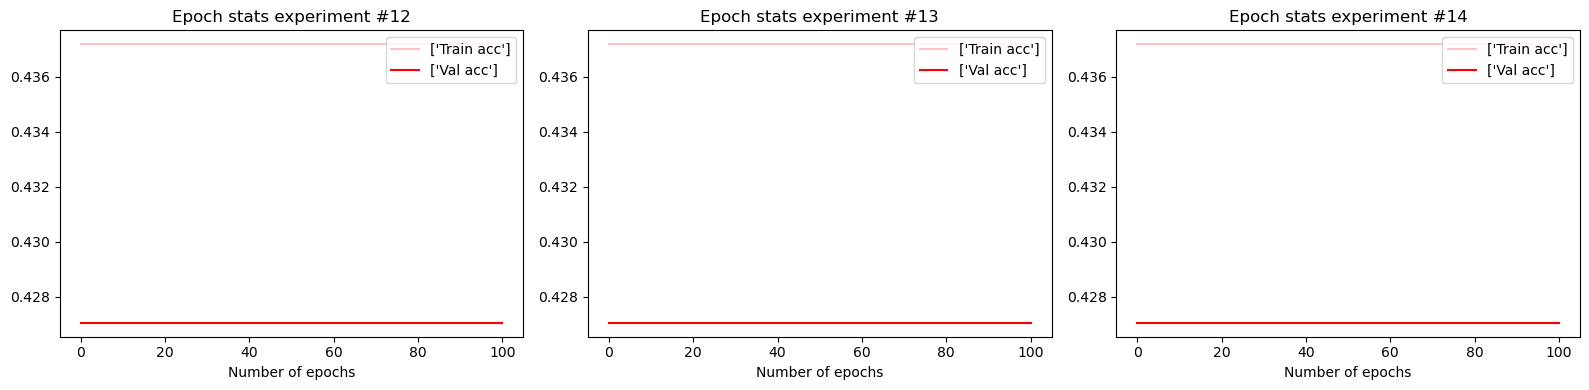

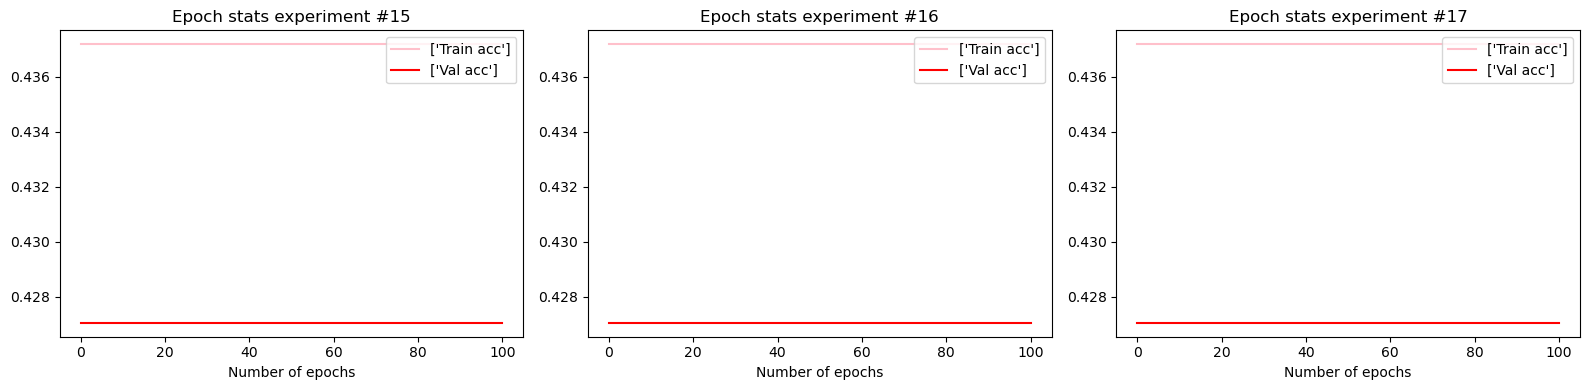

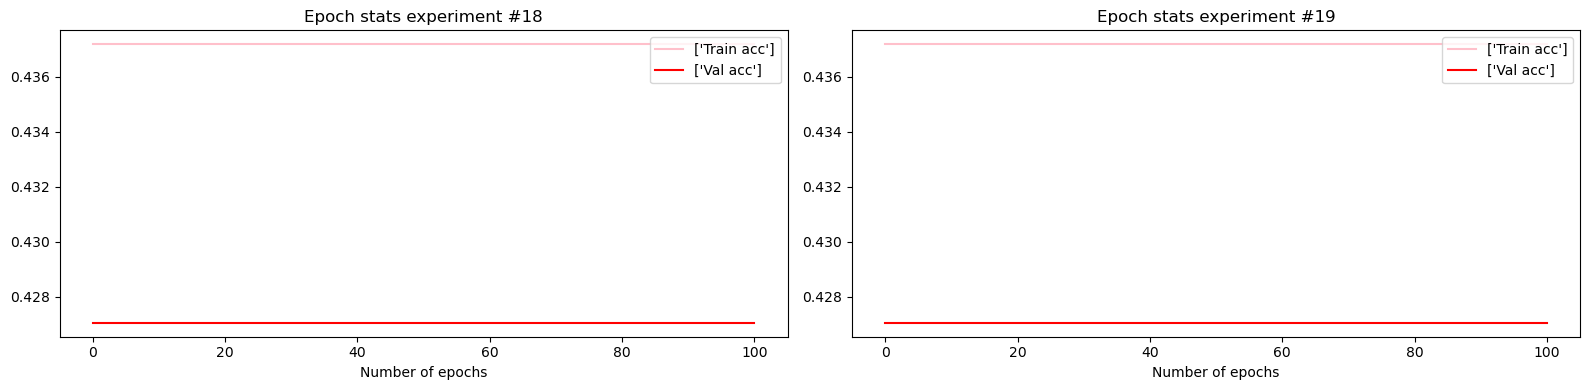

In [41]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

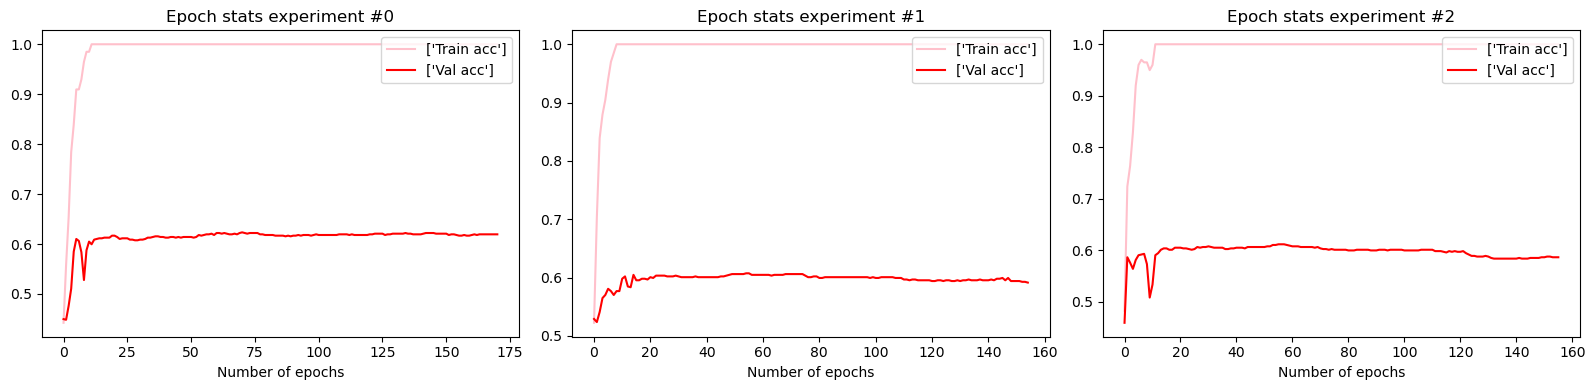

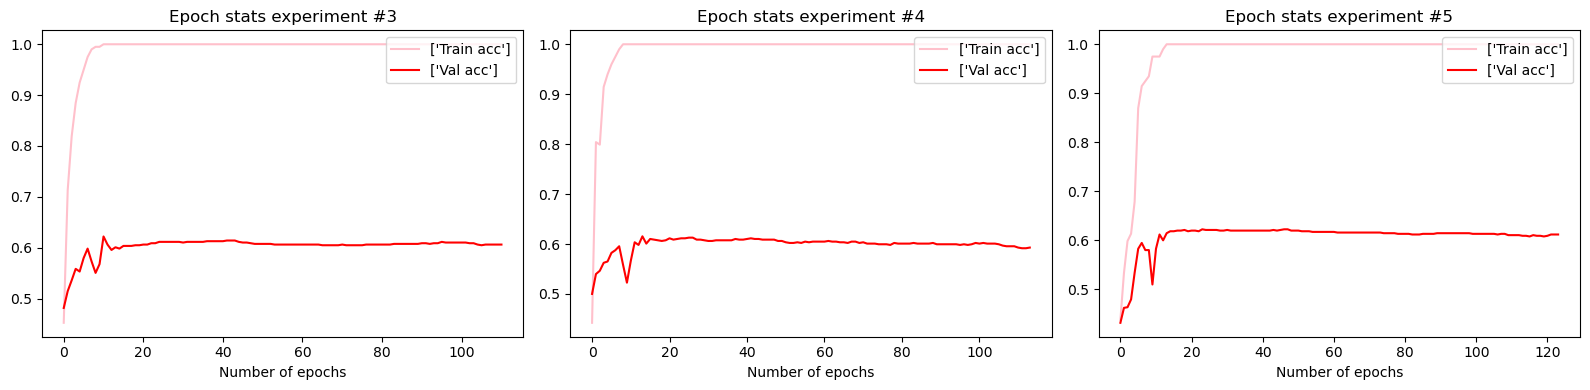

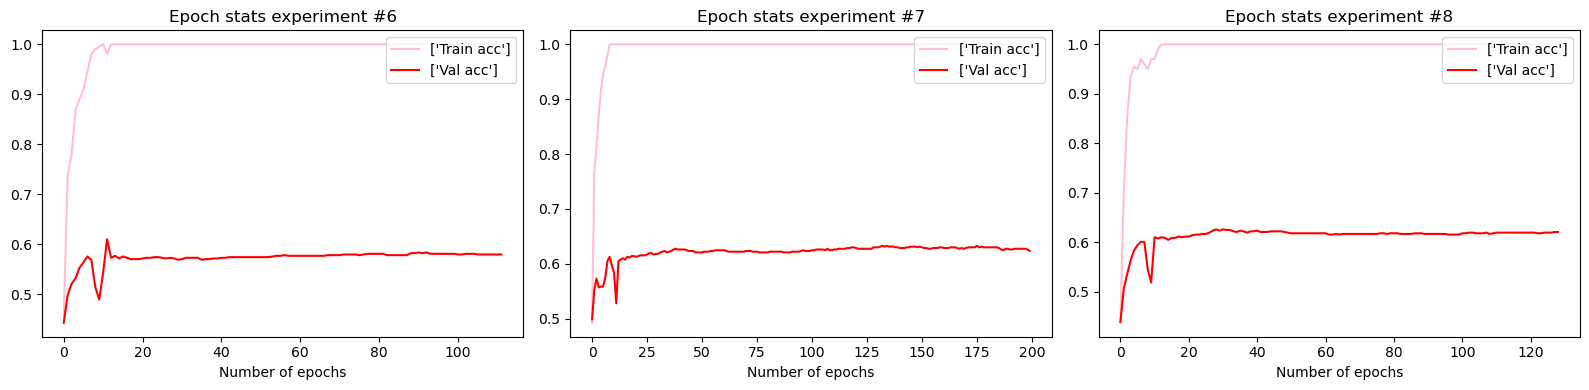

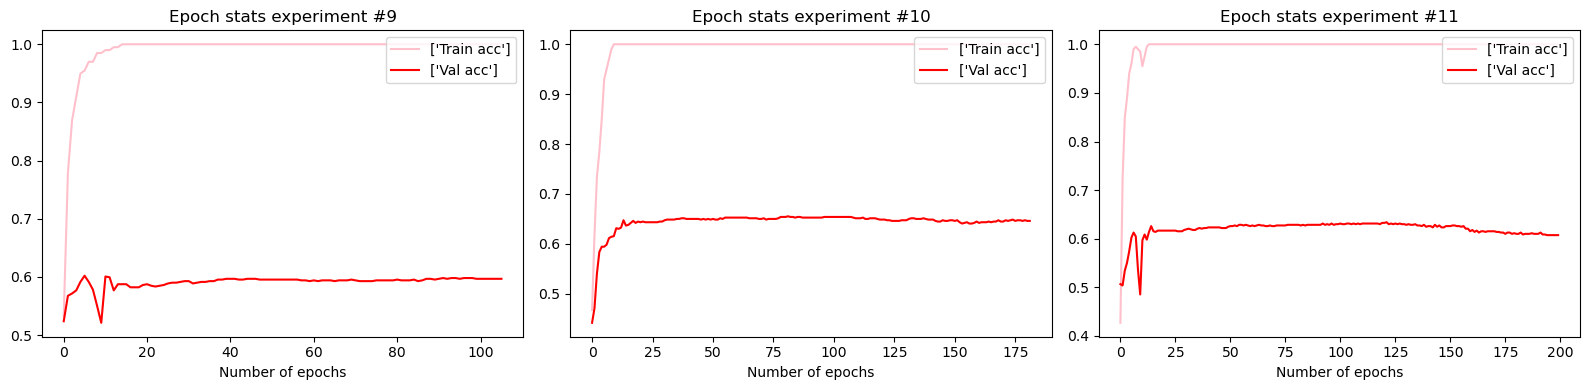

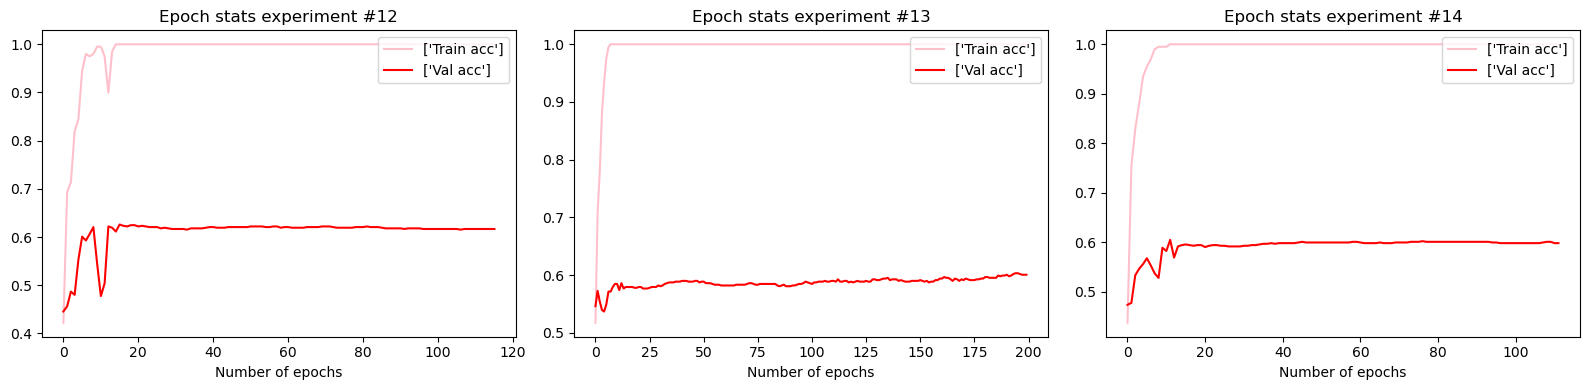

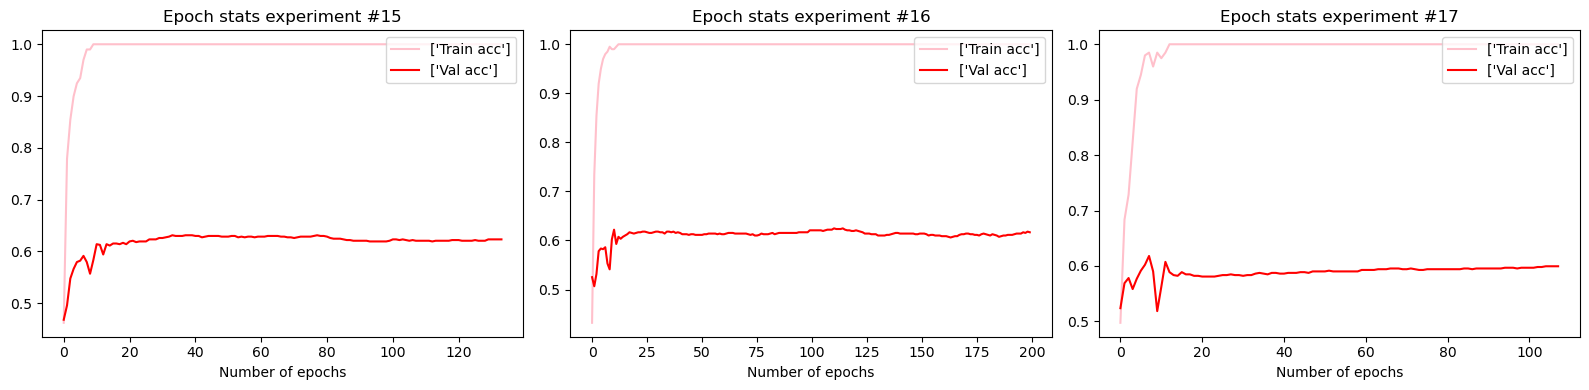

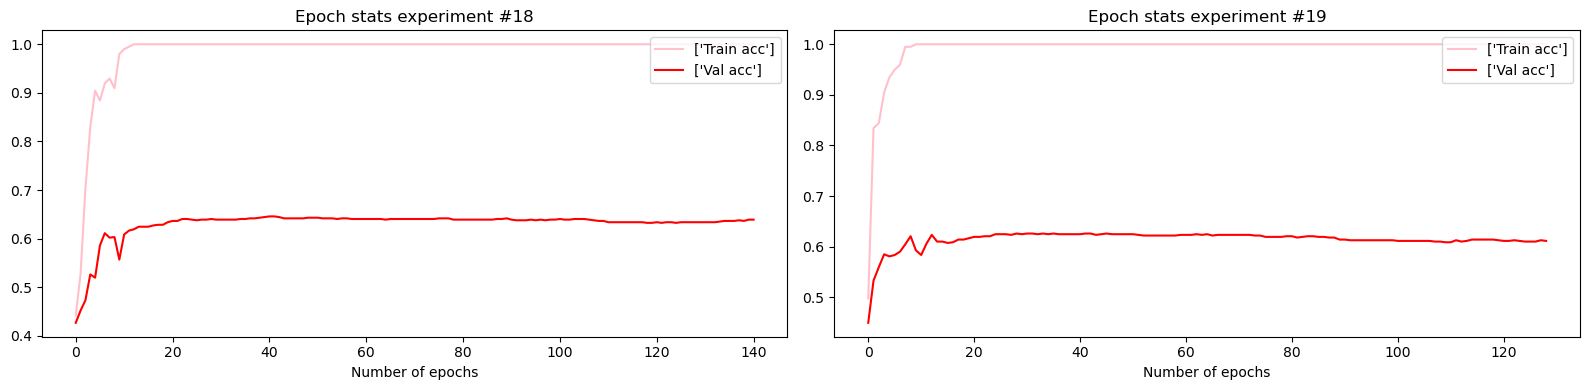

In [42]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [43]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('best_LSTM_model_skip20'))
best_cnn_model = CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('best_CNN_model_skip20'))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('best_DEEPSET_model_skip20'))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('best_DEEPSETV2_model_skip20'))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('best_FEEDFORWARD_model_skip20'))

C:\Users\juand\AppData\Local\Temp\ipykernel_55860\3683513133.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_lstm_model.load_state_dict(torch.load('best_LSTM_model_

<All keys matched successfully>

In [44]:
get_summary_df(["CNN", "LSTM", "DEEPSET", "DEEPSETv2", "FEEDFORWARD"], [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies], [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions], [cnn_recalls, lstm_recalls, deepset_recalls, deepsetv2_recalls, feedforward_recalls], [cnn_f1s, lstm_f1s, deepset_f1s, deepsetv2_f1s, feedforward_f1s])

        Modelo  Accuracy  Precision    Recall  F1-score
0          CNN  0.979111   0.971471  0.981046  0.976235
1         LSTM  0.949271   0.924927  0.962092  0.943144
2      DEEPSET  0.629642   0.575940  0.580743  0.578331
3    DEEPSETv2  0.437334   0.437334  1.000000  0.608535
4  FEEDFORWARD  0.630305   0.584020  0.537528  0.559811


## Top wrong predictions for best performing CNN model

In [45]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 

._,.,.._..,_..wu ,.___dr.,__,.,., | label: False | actual prediction: 0.9989573955535889
,,_,,,_,..,_,_wu ,_,,,,.___.,,dr_ | label: False | actual prediction: 0.9982218146324158
_.,..,.__.,...wu .dr,_...__.,,_,, | label: False | actual prediction: 0.9977407455444336
.,_,.__,__,,.,wu _..___._dr_,,__, | label: False | actual prediction: 0.9960309863090515
,,__..__,,.__,wu ._.,._dr_,,,_.__ | label: False | actual prediction: 0.9949154853820801
.__,__.,..,._,wu .,.,...__dr,,_.. | label: False | actual prediction: 0.9946840405464172
.,,_,,wu.._.,._, ,.,,_dr._.,,,.., | label: False | actual prediction: 0.9935257434844971
.....,__.,_,_,wu ,.,.___,__dr.,,. | label: False | actual prediction: 0.9935154914855957
_,_._,,,..,___wu dr,,,_.,__..,,.. | label: False | actual prediction: 0.9923779964447021
.,,.,.,_.,wu..__ ,dr.._...,_,,,.. | label: False | actual prediction: 0.9844086766242981

Top 10 false negatives: 

.__wu,..._.__.__ r,,..______,_.,_ | label: True | actual 

## Top wrong predictions for best performing LSTM model

In [46]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 

wu,..,.,,.,.._._ .,,dr_,,,._,._,. | label: False | actual prediction: 0.9999828338623047
.,,_,,wu.._.,._, ,.,,_dr._.,,,.., | label: False | actual prediction: 0.9999215602874756
.,,.,.,_.,wu..__ ,dr.._...,_,,,.. | label: False | actual prediction: 0.9998314380645752
,.,,,,wu.,_...._ ,,,,dr._.._.._.. | label: False | actual prediction: 0.999782145023346
,.,,,wu....____, .,.dr,_..__,_,,_ | label: False | actual prediction: 0.9995610117912292
,__.,,...wu.,... __,,._.dr,.,,.__ | label: False | actual prediction: 0.9991033673286438
wu__,,...,_,._._ ,_dr,_._,,___,_. | label: False | actual prediction: 0.998730480670929
,,...,,._wu.,... ,_._.,._,.dr.,_, | label: False | actual prediction: 0.9987234473228455
,.,wu.,.,__.,,_. dr.._.._.,_.,_,_ | label: False | actual prediction: 0.9986193180084229
_,,,,.wu..,_,,,, _,.__,.,dr.__,_, | label: False | actual prediction: 0.9984758496284485

Top 10 false negatives: 

,__.._..._uw_,,, .__.,._,.,....dr | label: True | actual pr

## Top wrong predictions for best performing DeepSets V1 model

In [47]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

._,.,wu,._,,_.., dr,_,__,,...,._, | label: False | actual prediction: 1.0
,,__.._._,.,,,_, ,_.,,,_,,,,.,cr, | label: False | actual prediction: 0.9999983310699463
,,_,.w,_,..___,, ,,_cr,,,,.,_,._. | label: False | actual prediction: 0.9999947547912598
.,_.,_,wu__,.___ dr_,.__,_,._,,_. | label: False | actual prediction: 0.9999923706054688
,,,,._,._,.__wu. dr,...__,.,_,_., | label: False | actual prediction: 0.9999897480010986
____,_.,,,_.uw__ ...cr.__,,...,,, | label: False | actual prediction: 0.9999866485595703
.,_.._..wu,_,.,, .cr_,,_._,.,,.,_ | label: False | actual prediction: 0.9999843835830688
.,_,____uw,,.__. _cr,,,_...,_,.,_ | label: False | actual prediction: 0.9999836683273315
._,,.._..____.__ ._.cr_.__.,..,_. | label: False | actual prediction: 0.9999828338623047
__,..._.,wu_,,,, ..dr,.....,_,.,_ | label: False | actual prediction: 0.9999747276306152

Top 10 false negatives: 

...__,.,,..___w_ _.,.___r_,___... | label: True | actual prediction: 1.4

## Top wrong predictions for best performing DeepSets V2 model

In [48]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

._,,_.___.,,__.. .,.,,.,.,,r__.,_ | label: True | actual prediction: 0.5
.,,._,,,.,uw,.._ __,r___,,,_,_,._ | label: True | actual prediction: 0.5
_.uw,_._,.,...._ ,._.,..,_,,._r,. | label: True | actual prediction: 0.5
.__,_._uw.,__,__ ,.,,..,,._.r,_., | label: True | actual prediction: 0.5
,_,.,.,.__wu_,_, _._,,.__.__.,_r, | label: True | actual prediction: 0.5
___.,,w.,.,,_,.. .,_...,dr_,_.... | label: True | actual prediction: 0.5
,.,,.,.,_..uw_., ,..,.._r_,,__,_. | label: True | actual prediction: 0.5
w__,,.,___,.._,_ _,._.,.,dr,,.,__ | label: True | actual prediction: 0.5
,...w.._,.,._,.. .._,.__,_,,.,r., | label: True | actual prediction: 0.5
_.._,w.__.__.... .,.._._,___r__,. | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [49]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

._,.,wu,._,,_.., dr,_,__,,...,._, | label: False | actual prediction: 1.0
,,,,._,._,.__wu. dr,...__,.,_,_., | label: False | actual prediction: 0.9999978542327881
,,_,.w,_,..___,, ,,_cr,,,,.,_,._. | label: False | actual prediction: 0.9999977350234985
,__..,.,._,.._., __..,._,,.,cr_,, | label: False | actual prediction: 0.999997615814209
_uw.__.,,,,_,__. ,cr_,,,.,.,,.,__ | label: False | actual prediction: 0.9999955892562866
,_,,_,._._.,.,,_ ,_,_,,___cr_,.._ | label: False | actual prediction: 0.9999954700469971
_,_,_...__,wu.,, ._,cr,..,..,,,__ | label: False | actual prediction: 0.9999936819076538
._,,.._..____.__ ._.cr_.__.,..,_. | label: False | actual prediction: 0.999992847442627
.__,,__,,,___uw. .,,__,__,_,_,cr. | label: False | actual prediction: 0.9999855756759644
.,..w,_,._._,,_. ._,cr,..,__.,.,, | label: False | actual prediction: 0.9999830722808838

Top 10 false negatives: 

.,._,..,._,.,.,. .,_.._dr.,_,_._. | label: True | actual prediction: 7.277

# Saving Notebook State

In [50]:
import dill
# dill.dump_session('notebook_env_skipping_20.db')

# Loading Notebook State

In [51]:
import dill
# dill.load_session('notebook_env_skipping_20.db')